# Movie Poster: can we predict the genre from it?
![](https://miro.medium.com/max/3840/1*jbfWuj3RSAAvmJeBwLWbsw.jpeg)

---

Introduction

> For movie viewers, the movie posters are one of the first impressions which humans use to get cues
about the movie content and its genre. Humans can grasp the cues like color, expressions on the faces of actors etc to quickly determine the genre (horror, comedy, animation etc). It has been shown that color characteristics of an image like hues, saturation, brightness, contour etc. affect human emotions. A given situation arouses these emotions in humans. If humans are able to predict genre of a movie by a single glance at its poster, then we can assume that the color characteristics, local texture based features and structural cues of posters possess some characteristics which could be utilized in machine learning algorithms to predict its genre.



## 1. PREPARATION

### 1.1. Import libraries

In [1]:
#!pip install tensorflow
#!pip install seaborn

In [2]:
import shutil
import os
import pathlib
import zipfile
from glob import glob
import logging
import warnings
import sys
import sklearn
import json
import urllib.request
import random

import numpy as np 
import pandas as pd
import tensorflow as tf
from keras.preprocessing import image

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.style as style
from PIL import Image
import seaborn as sns

from tqdm import tqdm
from itertools import chain
from collections import Counter, defaultdict


from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, MaxPool2D
from keras.layers import Conv2D, MaxPooling2D


warnings.filterwarnings('ignore')
logging.getLogger("tensorflow").setLevel(logging.ERROR)
sns.set_style('white')

In [3]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


2022-03-26 14:46:16.534370: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-26 14:46:16.588727: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-26 14:46:16.589228: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [4]:
import random

In [5]:
#!git clone https://github.com/ismail-ondr/movieClassification.git

### 1.2 Locate dataset

In [6]:
PROJECT_FOLDER = 'movieClassification'
DATASET_PATH = os.path.join(PROJECT_FOLDER, "dataset")
DATASET_RAW_PATH = os.path.join(DATASET_PATH, "raw")


### 1.3 Clean and download data

Our dataset is a csv file that contain .....

In [7]:
# Take a look at the csv file
pd.set_option('display.max_colwidth', -1)
movie = pd.read_csv(PROJECT_FOLDER+"/MovieGenre.csv", encoding="ISO-8859-1", engine='python')
movie

,imdbId,Imdb Link,Title,IMDB Score,Genre,Poster
0,114709,http://www.imdb.com/title/tt114709,Toy Story (1995),8.3,Animation|Adventure|Comedy,"https://images-na.ssl-images-amazon.com/images/M/MV5BMDU2ZWJlMjktMTRhMy00ZTA5LWEzNDgtYmNmZTEwZTViZWJkXkEyXkFqcGdeQXVyNDQ2OTk4MzI@._V1_UX182_CR0,0,182,268_AL_.jpg"
1,113497,http://www.imdb.com/title/tt113497,Jumanji (1995),6.9,Action|Adventure|Family,"https://images-na.ssl-images-amazon.com/images/M/MV5BZTk2ZmUwYmEtNTcwZS00YmMyLWFkYjMtNTRmZDA3YWExMjc2XkEyXkFqcGdeQXVyMTQxNzMzNDI@._V1_UY268_CR10,0,182,268_AL_.jpg"
2,113228,http://www.imdb.com/title/tt113228,Grumpier Old Men (1995),6.6,Comedy|Romance,"https://images-na.ssl-images-amazon.com/images/M/MV5BMjQxM2YyNjMtZjUxYy00OGYyLTg0MmQtNGE2YzNjYmUyZTY1XkEyXkFqcGdeQXVyMTQxNzMzNDI@._V1_UX182_CR0,0,182,268_AL_.jpg"
3,114885,http://www.imdb.com/title/tt114885,Waiting to Exhale (1995),5.7,Comedy|Drama|Romance,"https://images-na.ssl-images-amazon.com/images/M/MV5BMTczMTMyMTgyM15BMl5BanBnXkFtZTcwOTc4OTQyMQ@@._V1_UY268_CR4,0,182,268_AL_.jpg"
4,113041,http://www.imdb.com/title/tt113041,Father of the Bride Part II (1995),5.9,Comedy|Family|Romance,"https://images-na.ssl-images-amazon.com/images/M/MV5BOTEyNzg5NjYtNDU4OS00MWYxLWJhMTItYWU4NTkyNDBmM2Y0XkEyXkFqcGdeQXVyMTQxNzMzNDI@._V1_UX182_CR0,0,182,268_AL_.jpg"
...,...,...,...,...,...,...
40103,83168,http://www.imdb.com/title/tt83168,Tanya's Island (1980),4.3,Drama,"https://images-na.ssl-images-amazon.com/images/M/MV5BMTQ1NzY4OTA1Ml5BMl5BanBnXkFtZTcwOTEzNjcyMQ@@._V1_UY268_CR4,0,182,268_AL_.jpg"
40104,82875,http://www.imdb.com/title/tt82875,Pacific Banana (1981),4.7,Comedy,"https://images-na.ssl-images-amazon.com/images/M/MV5BMTQ3MzU2NzM4OF5BMl5BanBnXkFtZTcwMDIxNDMzMQ@@._V1_UY268_CR4,0,182,268_AL_.jpg"
40105,815258,http://www.imdb.com/title/tt815258,Werewolf in a Womens Prison (2006),4.5,Horror,"https://images-na.ssl-images-amazon.com/images/M/MV5BMTY1MzAyMDk3Nl5BMl5BanBnXkFtZTcwMjI0Mzk2MQ@@._V1_UY268_CR4,0,182,268_AL_.jpg"
40106,79142,http://www.imdb.com/title/tt79142,Xiao zi ming da (1979),6.5,Action|Comedy,"https://images-na.ssl-images-amazon.com/images/M/MV5BMjA0NTQ2MTc0OF5BMl5BanBnXkFtZTYwMzU0NjQ5._V1_UX182_CR0,0,182,268_AL_.jpg"


In [8]:
# Checking the data frame
print(movie.isnull().sum())
print('Number of duplicated rows: ', movie.duplicated().sum())

imdbId        0  
Imdb Link     0  
Title         0  
IMDB Score    48 
Genre         145
Poster        725
dtype: int64
Number of duplicated rows:  593


In [9]:
# Drop null and duplicated:
movie.dropna(axis = 0, inplace = True)
movie.drop_duplicates(inplace = True)

# Drop urls don't contain ".jpg"
movie = movie[movie['Poster'].str.endswith('jpg')]

movie.reset_index(drop=True, inplace=True)

We start downloading all posters from the corrispondent link and we save each of them using as name of the related movie. In this way we maintain the relationship between movies and their poster images.

Note: some images could be corrupted during the download or they may not be found at all. For those reasons we check for corrupted images after download and also we drop from dataset rows corresponding to movie whose poster was not found.

Remove movies that don't have poster image 

In [10]:
list_image_id = [int(id.split('.')[0]) for id in os.listdir(DATASET_RAW_PATH)]

new = movie['imdbId'].isin(list_image_id)
movie[new]

,imdbId,Imdb Link,Title,IMDB Score,Genre,Poster
0,114709,http://www.imdb.com/title/tt114709,Toy Story (1995),8.3,Animation|Adventure|Comedy,"https://images-na.ssl-images-amazon.com/images/M/MV5BMDU2ZWJlMjktMTRhMy00ZTA5LWEzNDgtYmNmZTEwZTViZWJkXkEyXkFqcGdeQXVyNDQ2OTk4MzI@._V1_UX182_CR0,0,182,268_AL_.jpg"
1,113497,http://www.imdb.com/title/tt113497,Jumanji (1995),6.9,Action|Adventure|Family,"https://images-na.ssl-images-amazon.com/images/M/MV5BZTk2ZmUwYmEtNTcwZS00YmMyLWFkYjMtNTRmZDA3YWExMjc2XkEyXkFqcGdeQXVyMTQxNzMzNDI@._V1_UY268_CR10,0,182,268_AL_.jpg"
2,113228,http://www.imdb.com/title/tt113228,Grumpier Old Men (1995),6.6,Comedy|Romance,"https://images-na.ssl-images-amazon.com/images/M/MV5BMjQxM2YyNjMtZjUxYy00OGYyLTg0MmQtNGE2YzNjYmUyZTY1XkEyXkFqcGdeQXVyMTQxNzMzNDI@._V1_UX182_CR0,0,182,268_AL_.jpg"
3,114885,http://www.imdb.com/title/tt114885,Waiting to Exhale (1995),5.7,Comedy|Drama|Romance,"https://images-na.ssl-images-amazon.com/images/M/MV5BMTczMTMyMTgyM15BMl5BanBnXkFtZTcwOTc4OTQyMQ@@._V1_UY268_CR4,0,182,268_AL_.jpg"
4,113041,http://www.imdb.com/title/tt113041,Father of the Bride Part II (1995),5.9,Comedy|Family|Romance,"https://images-na.ssl-images-amazon.com/images/M/MV5BOTEyNzg5NjYtNDU4OS00MWYxLWJhMTItYWU4NTkyNDBmM2Y0XkEyXkFqcGdeQXVyMTQxNzMzNDI@._V1_UX182_CR0,0,182,268_AL_.jpg"
...,...,...,...,...,...,...
38633,83291,http://www.imdb.com/title/tt83291,Los violadores (1981),5.5,Action|Thriller,"https://images-na.ssl-images-amazon.com/images/M/MV5BMTk3YmM3ZjktZDg0MS00NDc1LTk1MmUtZDBiM2QyNjMxNDdkXkEyXkFqcGdeQXVyMjUyNDk2ODc@._V1_UY268_CR3,0,182,268_AL_.jpg"
38634,83168,http://www.imdb.com/title/tt83168,Tanya's Island (1980),4.3,Drama,"https://images-na.ssl-images-amazon.com/images/M/MV5BMTQ1NzY4OTA1Ml5BMl5BanBnXkFtZTcwOTEzNjcyMQ@@._V1_UY268_CR4,0,182,268_AL_.jpg"
38635,82875,http://www.imdb.com/title/tt82875,Pacific Banana (1981),4.7,Comedy,"https://images-na.ssl-images-amazon.com/images/M/MV5BMTQ3MzU2NzM4OF5BMl5BanBnXkFtZTcwMDIxNDMzMQ@@._V1_UY268_CR4,0,182,268_AL_.jpg"
38636,815258,http://www.imdb.com/title/tt815258,Werewolf in a Womens Prison (2006),4.5,Horror,"https://images-na.ssl-images-amazon.com/images/M/MV5BMTY1MzAyMDk3Nl5BMl5BanBnXkFtZTcwMjI0Mzk2MQ@@._V1_UY268_CR4,0,182,268_AL_.jpg"


In [11]:
list_image_id = [int(id.split('.')[0]) for id in os.listdir(DATASET_RAW_PATH)]
movie = movie[movie['imdbId'].isin(list_image_id)]

In [12]:
print(len(os.listdir(DATASET_RAW_PATH)))
print(movie[new].shape)

35925
(35925, 6)


In [13]:
# checking downloaded images and dataframe rows is the same
len(os.listdir(DATASET_RAW_PATH)) == movie.shape[0]

True

In [14]:
# save it to csv file
movie.to_csv(PROJECT_FOLDER +'/movie_genre.csv', encoding='utf-8')

In [15]:
df = pd.read_csv(PROJECT_FOLDER +'/movie_genre.csv')
df = df[['imdbId', 'Genre']] # we only need 'imdbId', 'Genre' column for the work 
df 

,imdbId,Genre
0,114709,Animation|Adventure|Comedy
1,113497,Action|Adventure|Family
2,113228,Comedy|Romance
3,114885,Comedy|Drama|Romance
4,113041,Comedy|Family|Romance
...,...,...
35920,83291,Action|Thriller
35921,83168,Drama
35922,82875,Comedy
35923,815258,Horror


## 2. DATA EXPLORATION

First, let's see which movie genres that we have in the dataset.

In [16]:
labels_list = list(chain.from_iterable([i.split("|") for i in df['Genre'].values]))
labels_set = set(labels_list)


print("There is {} unique labels including {}".format(len(labels_set), labels_set))

There is 28 unique labels including {'Animation', 'News', 'Short', 'Comedy', 'Mystery', 'Documentary', 'Film-Noir', 'Western', 'Adventure', 'Horror', 'Sci-Fi', 'Action', 'War', 'Adult', 'Romance', 'Music', 'Game-Show', 'Thriller', 'Fantasy', 'Crime', 'Musical', 'Reality-TV', 'History', 'Talk-Show', 'Family', 'Biography', 'Sport', 'Drama'}


Display the distribution of these genres.

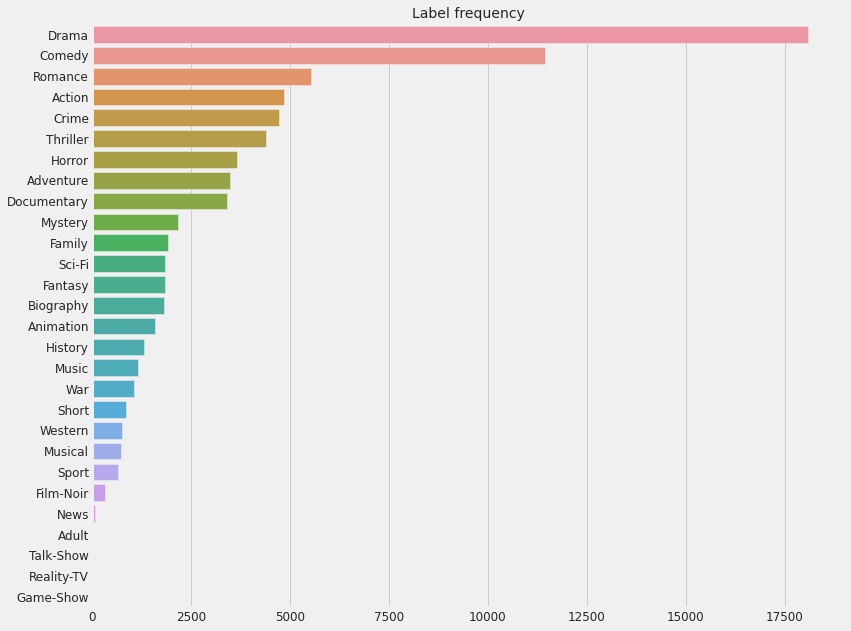

In [17]:
# Get label frequencies in descending order
label_freq = df['Genre'].apply(lambda s: str(s).split('|')).explode().value_counts().sort_values(ascending=False)

# Bar plot
style.use("fivethirtyeight")
plt.figure(figsize=(12,10))
sns.barplot(y=label_freq.index.values, x=label_freq, order=label_freq.index)
plt.title("Label frequency", fontsize=14)
plt.xlabel("")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

As we can see, our data is heavily imbalanced with respect genres.There are many occurrences of genres like "Comedy" and "Drama" and a very low number for other ones. 
We will consider as a rare label every label that is covered by less than 1000 posters in our dataset and they are very hard to predict due to lack of sufficient data. So, we need to make some transformation in the label column (Genre) where we ignore infrequent labels by hiding them.



In [18]:
# Create a list of rare labels
rare = list(label_freq[label_freq<10000].index) # 1000
print("We will be ignoring these rare labels:", rare)

We will be ignoring these rare labels: ['Romance', 'Action', 'Crime', 'Thriller', 'Horror', 'Adventure', 'Documentary', 'Mystery', 'Family', 'Sci-Fi', 'Fantasy', 'Biography', 'Animation', 'History', 'Music', 'War', 'Short', 'Western', 'Musical', 'Sport', 'Film-Noir', 'News', 'Adult', 'Talk-Show', 'Reality-TV', 'Game-Show']


In [19]:
# Transform Genre into a list of labels and remove the rare ones
df['Genre'] = df['Genre'].apply(lambda s: [l for l in str(s).split('|') if l not in rare])
df.head()

,imdbId,Genre
0,114709,[Comedy]
1,113497,[]
2,113228,[Comedy]
3,114885,"[Comedy, Drama]"
4,113041,[Comedy]


In [20]:
counter = 0
for i in df['Genre']:
    if not (i):
        i.append("Other")

In [21]:
df.head()

,imdbId,Genre
0,114709,[Comedy]
1,113497,[Other]
2,113228,[Comedy]
3,114885,"[Comedy, Drama]"
4,113041,[Comedy]


In [22]:
# samples = random.sample(os.listdir(DATASET_RAW_PATH),9)
# plt.figure(figsize=(20, 20))
# for index, image_name in enumerate(samples):
#     index += 1
#     plt.subplot(3, 3, index)

#     img = mpimg.imread(DATASET_RAW_PATH + '/' + image_name)
#     plt.imshow(img)

#     genre = df.loc[df['imdbId'] == int(image_name.split('.')[0]), 'Genre'].values[0]
#     plt.title("Genre: {}".format(genre))
#     plt.axis("off")

# plt.show()

## 3. DATA PRE-PROCESSING

To speeding up our learning and give time for improving model, we choose to work on a small sample of dataset first.

In [23]:
from sklearn.utils import shuffle

sample_df = df.copy()
# sample_df = shuffle(sample_df)
# sample_df = sample_df[:10000]

Turning the filename into filepaths so that we can read the image from its directory later

In [24]:
from sklearn.model_selection import train_test_split

X = [os.path.join(DATASET_RAW_PATH, str(i) + '.jpg') for i in sample_df['imdbId']]
y = sample_df['Genre']
train_img, val_img, train_label, val_label = train_test_split(X[0:int(len(X)/2)], y[0:int(len(y)/2)], test_size = 0.2, random_state = 10)
#train_img, val_img, train_label, val_label = train_test_split(X, y, test_size = 0.2, random_state = 10)

TRAIN_SAMPLES = len(train_img)
VAL_SAMPLES = len(val_img)

print (TRAIN_SAMPLES, VAL_SAMPLES)

14369 3593


In [25]:
print(int(len(X)/2))
print(int(len(y)/2))


17962
17962


In [26]:
from sklearn.preprocessing import MultiLabelBinarizer

# Fit multi-label binarizer on the training set
mlb = MultiLabelBinarizer()
mlb.fit(train_label)

# Print out label map 
print('Labels: ')
label_map = {}
for i, label in enumerate(mlb.classes_):
    label_map[i] = label
    print('{}. {}'.format(i, label))

# Define num. of labels 
N_LABELS = len(mlb.classes_)

Labels: 
0. Comedy
1. Drama
2. Other


In [27]:
# Transform the targets of both training set and validation set
y_train = mlb.transform(train_label)
y_val = mlb.transform(val_label)

# Print 3 examples
for i in range(3):
    print(train_img[i], y_train[i])

movieClassification/dataset/raw/144117.jpg [0 0 1]
movieClassification/dataset/raw/79550.jpg [0 1 0]
movieClassification/dataset/raw/275915.jpg [1 1 0]


In [28]:
for i in range(len(y_train)):
    if((y_train[i] == [0,0,0]).all()):
        print("var")
        break

In [29]:
import cv2
IMG_SIZE = 200

In [30]:
my_train = []

counter = 0
for train in train_img:
#     image = tf.io.read_file(train)
#     image = tf.image.decode_jpeg(image, channels=3)
#     image = tf.image.resize(image, [192, 192])
#     image = image / 255.0
    img = cv2.imread(train)
    #img = img / 255
    img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
    my_train.append(img)
    counter +=1
    #print(counter)


In [31]:
my_val = []

counter = 0
for val in val_img:
    img = cv2.imread(val)
    #img = img / 255
    img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
    # image = tf.io.read_file(val)
    # image = tf.image.decode_jpeg(image, channels=3)
    # image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    my_val.append(img)
    counter +=1
    #print(counter)

In [32]:
x_train = np.array(my_train).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
y_train = np.array(y_train).reshape(len(y_train),len(y_train[0]))

#x_test = np.array(my_val).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
#y_test = np.array(y_val).reshape(len(y_val),len(y_val[0]))

In [33]:
x_test = np.array(my_val).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
y_test = np.array(y_val).reshape(len(y_val),len(y_val[0]))

In [34]:
print(x_train.shape)
print(y_train.shape)

print(x_test.shape)
print(y_test.shape)

(14369, 200, 200, 3)
(14369, 3)
(3593, 200, 200, 3)
(3593, 3)


In [42]:

# model = Sequential()
# model.add(Conv2D(16, (3,3), activation='relu', input_shape =(IMG_SIZE,IMG_SIZE,3))) # x_train.shape[1:]
# model.add(BatchNormalization())
# #model.add(Dropout(0.3))

# model.add(Conv2D(32, (3,3), activation='relu'))
# model.add(BatchNormalization())
# model.add(MaxPool2D(2,2))
# #model.add(Dropout(0.3))

# model.add(Conv2D(64, (3,3), activation='relu'))
# model.add(BatchNormalization())
# model.add(MaxPool2D(2,2))
# #model.add(Dropout(0.4))

# model.add(Conv2D(128, (3,3), activation='relu'))
# model.add(BatchNormalization())
# model.add(MaxPool2D(2,2))
# #model.add(Dropout(0.5))

# model.add(Flatten())

# model.add(Dense(1024, activation='relu'))
# model.add(BatchNormalization())
# #model.add(Dropout(0.4))


# model.add(Dense(1024, activation='relu'))
# model.add(BatchNormalization())
# #model.add(Dropout(0.4))

# model.add(Dense(512, activation='relu'))
# model.add(BatchNormalization())
# #model.add(Dropout(0.4))

# model.add(Dense(512, activation='relu'))
# model.add(BatchNormalization())
# #model.add(Dropout(0.4))

# model.add(Dense(256, activation='relu'))
# model.add(BatchNormalization())
# #model.add(Dropout(0.4))

# model.add(Dense(9, activation='sigmoid'))

# model = tf.keras.applications.DenseNet169(
#     include_top=False,
#     weights=None,
#     input_tensor=None,
#     input_shape=(IMG_SIZE,IMG_SIZE,3),
#     pooling=None
# )


# model = tf.keras.Sequential([
#     model,
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(1024, activation = 'relu'),
#     tf.keras.layers.Dense(128, activation = 'relu'),
#     #tf.keras.layers.GlobalAveragePooling2D(),
#     tf.keras.layers.Dense(3, activation = 'sigmoid')])  

model = tf.keras.applications.MobileNetV2(input_shape=(IMG_SIZE,IMG_SIZE,3), include_top=False)

model = tf.keras.Sequential([
    model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation = 'relu'),
    tf.keras.layers.Dense(128, activation = 'relu'),
    #tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(3, activation = 'sigmoid')])  



In [43]:

model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 100, 100, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 100, 100, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [ ]:
# Batch Stats Collector that inherits Keras Callback
class CollectBatchStats(tf.keras.callbacks.Callback):
    def __init__(self):
        self.batch_losses = []
        self.batch_acc = []
        self.batch_val_losses = []
        self.batch_val_acc = []

    def on_train_batch_end(self, batch, logs=None):
        self.batch_losses.append(logs['loss'])
        self.batch_acc.append(logs['acc'])
        # reset_metrics: the metrics returned will be only for this batch. 
        # If False, the metrics will be statefully accumulated across batches.
        self.model.reset_metrics()
  
    def on_test_batch_end(self, batch, logs=None):
        self.batch_val_losses.append(logs['loss'])
        self.batch_val_acc.append(logs['acc'])
        # reset_metrics: the metrics returned will be only for this batch. 
        # If False, the metrics will be statefully accumulated across batches.
        self.model.reset_metrics()

# Plot learning curve 
def plot_stats(training_stats, val_stats, x_label='Training Steps', stats='loss'):
    stats, x_label = stats.title(), x_label.title()
    legend_loc = 'upper right' if stats=='loss' else 'lower right'
    training_steps = len(training_stats)
    test_steps = len(val_stats)

    plt.figure()
    plt.ylabel(stats)
    plt.xlabel(x_label)
    plt.plot(training_stats, label='Training ' + stats)
    plt.plot(np.linspace(0, training_steps, test_steps), val_stats, label='Validation ' + stats)
    plt.ylim([0,max(plt.ylim())])
    plt.legend(loc=legend_loc)
    plt.show()

In [ ]:
from tensorflow.keras.optimizers import Adam

In [ ]:
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate = 0.005), metrics=['accuracy'])

In [ ]:
#tf.compat.v1.disable_eager_execution()

In [ ]:
# Train model
history = model.fit(x_train, y_train, batch_size=32, epochs=10, validation_data=(x_test, y_test))

In [ ]:
plt.figure(figsize = (15, 10))

plot_stats(history.history['loss'], history.history['val_loss'], x_label='Epochs', stats='loss')
plot_stats(history.history['accuracy'], history.history['val_accuracy'], x_label='Epochs', stats='accuracy');

In [ ]:
model.save('drive/MyDrive/Colab Notebooks/movie_poster2.h5')

In [ ]:
model = tf.keras.models.load_model('drive/MyDrive/Colab Notebooks/AlexNetModel.h5')

In [ ]:
IMG_SIZE = 350

In [ ]:
def show_prediction(title, df, model):
    
    # Get movie info
    # imdbId = df.loc[df['Title']==title]['imdbId'].iloc[0]
    # genre = df.loc[df['Title']==title]['Genre'].iloc[0]
    # img_path = os.path.join(DATASET_RAW_PATH, str(imdbId)+'.jpg')

    #
    imdbId = df.loc[title]['imdbId']
    genre = df.loc[title]['Genre']
    img_path = os.path.join(DATASET_RAW_PATH, str(imdbId)+'.jpg')
    #

    img = cv2.imread(img_path)
    #img = img / 255
    img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
    img = np.expand_dims(img, axis=0)
    #
    # Read and prepare image
    # img = image.load_img(img_path, target_size=(IMG_SIZE,IMG_SIZE,3))
    # img = image.img_to_array(img)
    # img = img/255
    # img = np.expand_dims(img, axis=0)

    # Generate prediction
    prediction = (model.predict(img) > 0.5).astype('int')
    prediction = pd.Series(prediction[0])
    prediction.index = mlb.classes_
    prediction = prediction[prediction==1].index.values

    # Dispaly image with prediction
    style.use('default')
    plt.figure(figsize=(8,4))
    plt.imshow(Image.open(img_path))
    plt.title('\n\n{}\n\nGenre\n{}\n\nPrediction\n{}\n'.format(title, genre, list(prediction)), fontsize=9)
    plt.show()

Let's check some predictions

In [ ]:
show_prediction(random.randint(0,1000), movie, model)


In [ ]:
titles = ["Toy Story (1995)",
          "Captain America: The First Avenger (2011)",
          "Stand by Me Doraemon (2014)",
          "Titanic (1997)",
          "Annabelle (2014)",
          "Chef (2014)"]

for t in titles:
    show_prediction(t, movie, model)

## F1-score

In [ ]:
@tf.function
def macro_soft_f1(y, y_hat):
    """Compute the macro soft F1-score as a cost (average 1 - soft-F1 across all labels).
    Use probability values instead of binary predictions.
    
    Args:
        y (int32 Tensor): targets array of shape (BATCH_SIZE, N_LABELS)
        y_hat (float32 Tensor): probability matrix from forward propagation of shape (BATCH_SIZE, N_LABELS)
        
    Returns:
        cost (scalar Tensor): value of the cost function for the batch
    """
    y = tf.cast(y, tf.float32)
    y_hat = tf.cast(y_hat, tf.float32)
    tp = tf.reduce_sum(y_hat * y, axis=0)
    fp = tf.reduce_sum(y_hat * (1 - y), axis=0)
    fn = tf.reduce_sum((1 - y_hat) * y, axis=0)
    soft_f1 = 2*tp / (2*tp + fn + fp + 1e-16)
    cost = 1 - soft_f1 # reduce 1 - soft-f1 in order to increase soft-f1
    macro_cost = tf.reduce_mean(cost) # average on all labels
    return macro_cost

In [ ]:
@tf.function
def macro_f1(y, y_hat, thresh=0.5):val_acc
    """Compute the macro F1-score on a batch of observations (average F1 across labels)
    
    Args:
        y (int32 Tensor): labels array of shape (BATCH_SIZE, N_LABELS)
        y_hat (float32 Tensor): probability matrix from forward propagation of shape (BATCH_SIZE, N_LABELS)
        thresh: probability value above which we predict positive
        
    Returns:
        macro_f1 (scalar Tensor): value of macro F1 for the batch
    """
    y_pred = tf.cast(tf.greater(y_hat, thresh), tf.float32)
    tp = tf.cast(tf.math.count_nonzero(y_pred * y, axis=0), tf.float32)
    fp = tf.cast(tf.math.count_nonzero(y_pred * (1 - y), axis=0), tf.float32)
    fn = tf.cast(tf.math.count_nonzero((1 - y_pred) * y, axis=0), tf.float32)
    f1 = 2*tp / (2*tp + fn + fp + 1e-16)
    macro_f1 = tf.reduce_mean(f1)
    return macro_f1

In [ ]:
num_steps_train = tf.math.ceil(float(TRAIN_SAMPLES)/BATCH_SIZE)              
num_steps_val = tf.math.ceil(float(VAL_SAMPLES)/BATCH_SIZE)

model.compile(optimizer = 'adam',
               loss = macro_soft_f1,
               metrics = [macro_f1])

In [ ]:
# Train model
history = model.fit(train_ds,
                  steps_per_epoch = num_steps_train,
                  epochs = EPOCHS,
                  validation_data = val_ds,
                  validation_steps = num_steps_val,
                  callbacks=[cp_callback, earlystop])

In [ ]:
plt.figure(figsize = (15, 10))

plot_stats(history.history['loss'], history.history['val_loss'], x_label='Epochs', stats='loss')
plot_stats(history.history['macro_f1'], history.history['val_macro_f1'], x_label='Epochs', stats='macro_F1_score');

In [ ]:
titles = ["Toy Story (1995)",
          "Captain America: The First Avenger (2011)",
          "Stand by Me Doraemon (2014)",
          "Titanic (1997)",
          "Annabelle (2014)",
          "Chef (2014)"]

for t in titles:
    show_prediction(t, movie, model)